# **Diabetic Patient Readmission: Modeling**

This dataset was analyzed by numerous Virginia Commonwealth University faculty in a recent research article which is accompanied by feature descriptions. These can be found at https://www.hindawi.com/journals/bmri/2014/781670/tab1/.

In [1]:
#conda install -c conda-forge imbalanced-learn      https://imbalanced-learn.org/stable/references/index.html#api

import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, plot_roc_curve, roc_curve

from timeit import default_timer as timer

np.random.seed(42)

In [2]:
df1 = pd.read_csv("clean_data2.csv")
df1.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,Other
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,missing,...,No,Up,No,No,No,No,No,Ch,Yes,Other
2,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,missing,...,No,Up,No,No,No,No,No,Ch,Yes,Other
3,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,missing,...,No,Steady,No,No,No,No,No,Ch,Yes,Other
4,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,missing,...,No,Steady,No,No,No,No,No,No,Yes,Other


In [3]:
print('Percent "other" in "readmitted":',100 * round(1-(df1['readmitted'].value_counts()[1] / 
                                                        df1['readmitted'].value_counts().sum()), 5))

Percent "other" in "readmitted": 91.579


# Pre-processing:

In [4]:
df1 = df1.drop(columns=['encounter_id','patient_nbr'])    #irrelevant for modeling

In [5]:
X = df1.drop(columns=['readmitted'])
y = df1[['readmitted']].values.ravel()
X.shape, y.shape

((64781, 42), (64781,))

In [6]:
X = pd.get_dummies(X, drop_first=True)
X.head()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_diagnoses,...,insulin_Steady,insulin_Up,glyburide-metformin_No,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,metformin-rosiglitazone_Steady,metformin-pioglitazone_Steady,change_No,diabetesMed_Yes
0,6,25,1,1,41,0,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0
1,1,1,7,3,59,0,18,0,0,9,...,0,1,1,0,0,0,0,0,0,1
2,1,1,7,2,44,1,16,0,0,7,...,0,1,1,0,0,0,0,0,0,1
3,1,1,7,1,51,0,8,0,0,5,...,1,0,1,0,0,0,0,0,0,1
4,2,1,2,3,31,6,16,0,0,9,...,1,0,1,0,0,0,0,0,1,1


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split:

In [8]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.25, random_state=42)

In [9]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(48585, 2298) (16196, 2298) (48585,) (16196,)


In [10]:
print('Percent "other" in "readmitted" of y_train:', 100*(round(1-(pd.DataFrame(y_train).value_counts()[1] / 
                                                        pd.DataFrame(y_train).value_counts().sum()), 5)))

Percent "other" in "readmitted" of y_train: 91.598


In [11]:
y_test_df = pd.DataFrame(y_train)
y_test_df.value_counts()

Other    44503
<30       4082
dtype: int64

In [12]:
scale_pos_weight = round(44503/4082,2)
print(scale_pos_weight)

10.9


The above will be useful to know for future model evalutaion and some tuning.

# Model Tuning and Evaluation:

**K-Nearest Neighbors:**

In [11]:
knn = KNeighborsClassifier()

param_dist = {'n_neighbors': np.arange(1,40),
              'leaf_size': np.arange(1,50),
              'p': [1,2]}

knn_cv = RandomizedSearchCV(knn, param_dist, cv=5, verbose=2, n_jobs=-1)

In [12]:
start = timer()

knn_cv = knn_cv.fit(X_train, y_train)

end = timer()
print(f'{round(end - start)} seconds elapsed.')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
8949 seconds elapsed.


In [13]:
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.9159822990634969
Best Parameters: {'p': 1, 'n_neighbors': 28, 'leaf_size': 41}


In [11]:
params = {'p': 1, 'n_neighbors': 28, 'leaf_size': 41}
best_knn = KNeighborsClassifier(**params, n_jobs=-1) # ** unpacks dict values to function arguments

In [13]:
start = timer()

best_knn = best_knn.fit(X_train, y_train)

print('Training Accuracy:', best_knn.score(X_train, y_train))

end = timer()
print(f'{round(end-start)} seconds elapsed.')

Training Accuracy: 0.9159822990634969
1514 seconds elapsed.


91.598 percent accurate is mediocre in light of the fact that an estimator which simply predicts 'other' every time would achieve the same score on the training data.

In [14]:
y_pred = best_knn.predict(X_test)
print(classification_report(y_test, y_pred, labels=best_knn.classes_))

              precision    recall  f1-score   support

         <30       0.00      0.00      0.00      1373
       Other       0.92      1.00      0.96     14823

    accuracy                           0.92     16196
   macro avg       0.46      0.50      0.48     16196
weighted avg       0.84      0.92      0.87     16196



In [35]:
auc_score_tr = roc_auc_score(y_train, best_knn.predict_proba(X_train)[:,1])
auc_score_te = roc_auc_score(y_test, best_knn.predict_proba(X_test)[:,1])

print('Train AUC:', auc_score_tr)
print('Test AUC:', auc_score_te)

Train AUC: 0.721088731825609
Test AUC: 0.5706338926548618


Not the best AUC from the K-Nearest Neighbors model.

**Random Forest:**

In [14]:
max_depth = np.arange(10, 100, 10)
max_depth = np.append(max_depth, None)

rfclf = RandomForestClassifier(class_weight='balanced')

param_dist = {'max_depth': max_depth, 'n_estimators': np.arange(200, 2000, 200)}

rfclf_cv = RandomizedSearchCV(rfclf, param_dist, cv=5, verbose=2, n_jobs=-1)

In [15]:
start = timer()

rfclf_cv = rfclf_cv.fit(X_train, y_train)

end = timer()
print(f'{round(end - start)} seconds elapsed.')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
15801 seconds elapsed.


In [16]:
print("Best Score:" + str(rfclf_cv.best_score_))
print("Best Parameters: " + str(rfclf_cv.best_params_))

Best Score:0.9159822990634969
Best Parameters: {'n_estimators': 1800, 'max_depth': 90}


The best Random Forest Classifier to come out of RandomizedSearchCV seems to be overfitting

In [16]:
params = {'n_estimators': 1800, 'max_depth': 90, 'class_weight':'balanced'}
best_rf = RandomForestClassifier(**params, n_jobs=-1)

In [17]:
start = timer()

best_rf = best_rf.fit(X_train, y_train)

print('Training Accuracy:', best_rf.score(X_train, y_train))

end = timer()
print(f'{round(end-start)} seconds elapsed.')

Training Accuracy: 1.0
517 seconds elapsed.


In [18]:
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred, labels=best_rf.classes_))

              precision    recall  f1-score   support

         <30       0.00      0.00      0.00      1373
       Other       0.92      1.00      0.96     14823

    accuracy                           0.92     16196
   macro avg       0.46      0.50      0.48     16196
weighted avg       0.84      0.92      0.87     16196



In [37]:
auc_score_tr = roc_auc_score(y_train, best_rf.predict_proba(X_train)[:,1])
auc_score_te = roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1])

print('Train AUC:', auc_score_tr)
print('Test AUC:', auc_score_te)

Train AUC: 1.0
Test AUC: 0.6291421586077698


The roughly-tuned Random Forest classifier is very overfit to the training data, but is still managing a better AUC on the test data than the K-Nearest Neighbors model.
<br><br>
Unfortunately, neither of these two inital models seem to be doing a great job of identifying the patterns that constitute our positive class.

**XGBoost:**

In [13]:
xgbclf = xgb.XGBClassifier(objective='binary:logistic')

param_dist = {'learning_rate': np.arange(0.0, 1.0, 0.1),
              'n_estimators': np.arange(100, 1000, 100),
              'max_depth': np.arange(3, 15, 2),
              'scale_pos_weight': np.arange(8.0, 11.0, 0.5)}

xgbclf_cv = RandomizedSearchCV(xgbclf, param_dist, cv=5, verbose=2, n_jobs=-1)

Note: scale_pos_weight argument balances class weights and is = # of neg observations / # of pos observations

In [14]:
start = timer()

xgbclf_cv = xgbclf_cv.fit(X_train, y_train)

end = timer()
print(f'{round(end - start)} seconds elapsed.')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[08:18:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
27752 seconds elapsed.


In [15]:
print("Best Score:" + str(xgbclf_cv.best_score_))
print("Best Parameters: " + str(xgbclf_cv.best_params_))

Best Score:0.9160028815478028
Best Parameters: {'scale_pos_weight': 10.0, 'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.1}


In [16]:
params = xgbclf_cv.best_params_
best_xgb = xgb.XGBClassifier(**params, objective='binary:logistic', n_jobs=-1)

In [17]:
start = timer()

best_xgb = best_xgb.fit(X_train, y_train)

print('Training Accuracy:', best_xgb.score(X_train, y_train))

end = timer()
print(f'{round(end-start)} seconds elapsed.')

[08:27:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy: 0.9171143357003191
510 seconds elapsed.


In [18]:
y_pred = best_xgb.predict(X_test)
print(classification_report(y_test, y_pred, labels=best_xgb.classes_))

              precision    recall  f1-score   support

         <30       0.80      0.00      0.01      1373
       Other       0.92      1.00      0.96     14823

    accuracy                           0.92     16196
   macro avg       0.86      0.50      0.48     16196
weighted avg       0.91      0.92      0.88     16196



Immediately the precision score on our target class is looking much better than with any other model. A non-zero f1-score is also promising.

In [19]:
best_xgb.classes_

array(['<30', 'Other'], dtype=object)

In [20]:
auc_score_tr = roc_auc_score(y_train, best_xgb.predict_proba(X_train)[:,1])
auc_score_te = roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:,1])

print('Train AUC:', auc_score_tr)
print('Test AUC:', auc_score_te)

Train AUC: 0.8822310345707967
Test AUC: 0.630612113937421


In [21]:
features = X.keys()
imp = list(best_xgb.feature_importances_)
imp_df = pd.DataFrame((zip(features, imp)), columns =['Features', 'Importance scores'])
imp_df = imp_df.sort_values('Importance scores', ascending=False)
print(imp_df.head(50))

                                Features  Importance scores
1019                          diag_2_413           0.007994
210                         diag_1_250.6           0.004935
1               discharge_disposition_id           0.004827
1799                          diag_3_493           0.004763
650                           diag_1_820           0.004735
92    medical_specialty_Surgery-Vascular           0.004614
1037                          diag_2_433           0.004503
344                           diag_1_411           0.004444
247                           diag_1_291           0.004409
996                            diag_2_38           0.004126
2009                          diag_3_788           0.004032
457                           diag_1_552           0.003995
1746                          diag_3_426           0.003953
359                           diag_1_427           0.003922
343                           diag_1_410           0.003854
2128                          diag_3_996

It makes sense to see discharge_disposition_id at the top of this table, as it is indicative of the state of a patient upon discharge.

Diagnoses of 250.x indicate a diabetes-related diagnosis and so it makes sens to see many of these showing up here as well.

It is also sensible to see the affiliated medical specialties of Surgery-Vascular and Emergency/Trauma.

The medication Repaglinide also emerges as one of the more important factors. This, as well as the other present medications and ICD-9 codes, could be further discussed with domain experts to ensure the relative hierarchy of these features make sense.

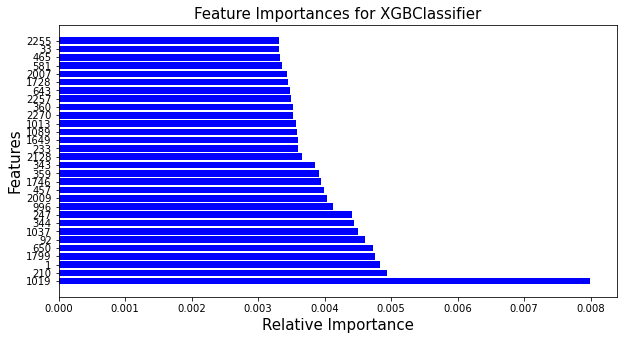

In [22]:
plt.figure(figsize=(10,5))
_=plt.barh(imp_df['Features'].head(30), imp_df['Importance scores'].head(30), align='center', color='b')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.title('Feature Importances for XGBClassifier',fontsize=15)
plt.yticks(imp_df['Features'].head(30), imp_df['Features'].head(30).index)
plt.show()

In [23]:
100*imp_df['Importance scores'].head(30).sum()

12.136096507310867

In [24]:
100*30/2298

1.3054830287206267

The above shows that the top 30 features explain 12.14% of the variance seen in the dataset, while making up only 1.31% of the total considered features. This shows a fair relationship to the top 30, but the model is definitely evaluating across *a lot* of features to attain a classification.

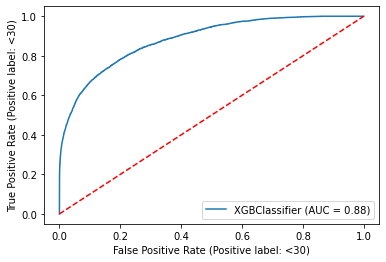

In [25]:
_=plot_roc_curve(best_xgb, X_train, y_train, pos_label='<30')
plt.plot([0, 1], [0, 1], 'k--', color='r')
plt.show()

A decent AUC

**Thresholding the xgb classifier:**

In [26]:
# 2nd arg for roc_curve must be POSITIVE class probas
fpr, tpr, thresholds = roc_curve(y_train, best_xgb.predict_proba(X_train)[:,0], pos_label='<30')
gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
best_thresh = thresholds[index]
print('Best Threshold =', best_thresh)
print('OptTPR:',tpr[index],'OptFPR:',fpr[index])

Best Threshold = 0.012019575
OptTPR: 0.7760901518863302 OptFPR: 0.19364986630114825


A TPR of 0.776 and FPR of 0.194 is the most optimized result yet. The model is honing in on a better understanding of the target class.

In [27]:
roc_data = pd.DataFrame(zip(fpr,tpr,thresholds,gmean),columns=['fpr','tpr','threshold','gmean'])
roc_data = roc_data.sort_values('tpr', ascending=False).reset_index(drop=True)
roc_data

,fpr,tpr,threshold,gmean
0,1.000000,1.000000,0.000145,0.000000
1,0.897647,1.000000,0.002994,0.319926
2,0.897760,1.000000,0.002992,0.319750
3,0.897805,1.000000,0.002992,0.319680
4,0.897827,1.000000,0.002991,0.319645
...,...,...,...,...
14356,0.000045,0.120284,0.118858,0.346812
14357,0.000000,0.115140,0.125090,0.339322
14358,0.000022,0.115140,0.124809,0.339319
14359,0.000000,0.000245,0.908958,0.015652


In [28]:
np.argmax(roc_data.gmean)

10625

In [29]:
roc_data.iloc[10620:10630]

,fpr,tpr,threshold,gmean
10620,0.194594,0.776335,0.011992,0.790737
10621,0.195043,0.776335,0.011983,0.790517
10622,0.194818,0.776335,0.011988,0.790627
10623,0.194773,0.776335,0.011989,0.790649
10624,0.194459,0.776090,0.011996,0.790679
10625,0.193650,0.776090,0.012020,0.791075
10626,0.194504,0.776090,0.011996,0.790657
10627,0.194594,0.776090,0.011993,0.790612
10628,0.193650,0.775845,0.012021,0.790951
10629,0.193605,0.775845,0.012025,0.790973


In [30]:
best_xgb.classes_

array(['<30', 'Other'], dtype=object)

In [31]:
threshold = 0.012020

X_test_proba = pd.DataFrame(best_xgb.predict_proba(X_test), columns=['Pos_class_proba','class'])

print(X_test_proba.head())

for i in range(len(X_test_proba)):
    if X_test_proba['Pos_class_proba'].iloc[i] > threshold:
        X_test_proba['class'].iloc[i] = '<30'
    else:
        X_test_proba['class'].iloc[i] = 'Other'

print(X_test_proba.head())

y_pred_thresh = X_test_proba

   Pos_class_proba     class
0         0.007046  0.992954
1         0.006253  0.993747
2         0.001424  0.998576
3         0.004121  0.995879
4         0.006551  0.993449
   Pos_class_proba  class
0         0.007046  Other
1         0.006253  Other
2         0.001424  Other
3         0.004121  Other
4         0.006551  Other


In [32]:
y_pred_thresh['class'].value_counts()

Other    11909
<30       4287
Name: class, dtype: int64

In [33]:
print(classification_report(y_test, y_pred_thresh['class'], labels=best_xgb.classes_))

              precision    recall  f1-score   support

         <30       0.13      0.41      0.20      1373
       Other       0.93      0.75      0.83     14823

    accuracy                           0.72     16196
   macro avg       0.53      0.58      0.52     16196
weighted avg       0.86      0.72      0.78     16196



Our best-looking classification report yet. The highest f1-score on our target class by a huge margin.

In [34]:
y_test_df = pd.DataFrame(y_test)
y_test_df.value_counts()

Other    14823
<30       1373
dtype: int64

**XGB With Over-Sampling of the minority (Target) class:**

In [82]:
from imblearn.over_sampling import RandomOverSampler

start=timer()

ros = RandomOverSampler(sampling_strategy=1, random_state=None)     #set 1:1 ratio for pos_class:neg_class
Xtr_res, ytr_res = ros.fit_resample(X_train, y_train)

end=timer()
print(f'{round(end-start)} seconds elapsed.')

1 seconds elapsed.


In [83]:
X_train.shape, y_train.shape

((48585, 2298), (48585,))

In [84]:
Xtr_res.shape, ytr_res.shape

((89006, 2298), (89006,))

In [85]:
pd.DataFrame(ytr_res).value_counts()

<30      44503
Other    44503
dtype: int64

In [86]:
pd.DataFrame(ytr_res).value_counts()[1]/pd.DataFrame(ytr_res).value_counts().sum()

0.5

In [91]:
res_xgbclf = xgb.XGBClassifier(objective='binary:logistic')

param_dist = {'learning_rate': np.arange(0.0, 1.0, 0.1),
              'n_estimators': np.arange(100, 1000, 100),
              'max_depth': np.arange(3, 15, 2)}

res_xgbclf_cv = RandomizedSearchCV(res_xgbclf, param_dist, cv=5, verbose=2, n_jobs=-1)

In [ ]:
start = timer()

res_xgbclf_cv = res_xgbclf_cv.fit(Xtr_res, ytr_res)

end = timer()
print(f'{round(end - start)} seconds elapsed.')

In [ ]:
print("Best Score:" + str(res_xgbclf_cv.best_score_))
print("Best Parameters: " + str(res_xgbclf_cv.best_params_))

In [92]:
params = {'n_estimators': 500, 'max_depth': 13, 'learning_rate': 0.5}
best_xgb_res = xgb.XGBClassifier(**params, objective='binary:logistic', n_jobs=-1)

In [93]:
start = timer()

best_xgb_res = best_xgb_res.fit(Xtr_res, ytr_res)

print('Training Accuracy:', best_xgb_res.score(Xtr_res, ytr_res))

end = timer()
print(f'{round(end-start)} seconds elapsed.')

[12:11:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy: 1.0
1393 seconds elapsed.


In [94]:
y_pred_res = best_xgb_res.predict(X_test)
print(classification_report(y_test, y_pred_res, labels=best_xgb_res.classes_))

              precision    recall  f1-score   support

         <30       0.18      0.06      0.09      1373
       Other       0.92      0.97      0.95     14823

    accuracy                           0.90     16196
   macro avg       0.55      0.52      0.52     16196
weighted avg       0.86      0.90      0.87     16196



A good improvement for simply oversampling to a 1:1 ratio on a roughly-tuned XGBClassifier model.

In [95]:
features = X.keys()
imp = list(best_xgb_res.feature_importances_)
imp_df = pd.DataFrame((zip(features, imp)), columns=['Features', 'Importance scores'])
print(imp_df)
imp_df = imp_df.sort_values('Importance scores', ascending=False)
print(imp_df.head(30))

                            Features  Importance scores
0                  admission_type_id           0.000516
1           discharge_disposition_id           0.001118
2                admission_source_id           0.000525
3                   time_in_hospital           0.000474
4                 num_lab_procedures           0.000497
...                              ...                ...
2293      glipizide-metformin_Steady           0.000000
2294  metformin-rosiglitazone_Steady           0.000000
2295   metformin-pioglitazone_Steady           0.000000
2296                       change_No           0.000444
2297                 diabetesMed_Yes           0.000602

[2298 rows x 2 columns]
                                        Features  Importance scores
1154                                  diag_2_583           0.008278
1450                                 diag_2_E936           0.006679
1563                                  diag_3_236           0.005233
314                            

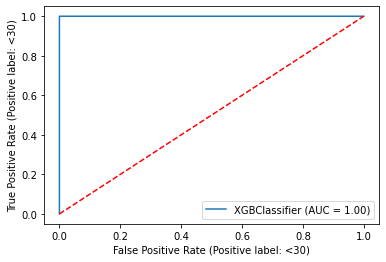

In [96]:
_=plot_roc_curve(best_xgb_res, Xtr_res, ytr_res, pos_label='<30')
plt.plot([0, 1], [0, 1], 'k--', color='r')
plt.show()

The model is overfitting, and will likely not generalize well.

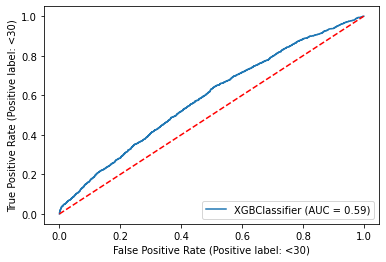

In [97]:
_=plot_roc_curve(best_xgb_res, X_test, y_test, pos_label='<30')
plt.plot([0, 1], [0, 1], 'k--', color='r')
plt.show()

0.59 is a poor AUC, but with more tuning, the oversampling method would probably prove beneficial, especially when combined with the scale_pos_weight argument that better-handles the imbalanced classes.

In [98]:
# 2nd arg for roc_curve must be POSITIVE class probas
fpr, tpr, thresholds = roc_curve(y_test, best_xgb_res.predict_proba(X_test)[:,0], pos_label='<30')
gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
best_thresh = thresholds[index]
print('Best Threshold =', best_thresh)
print('OptTPR:',tpr[index],'OptFPR:',fpr[index])

Best Threshold = 0.90365255
OptTPR: 1.0 OptFPR: 0.0


In [99]:
# 2nd arg for roc_curve must be POSITIVE class probas
fpr, tpr, thresholds = roc_curve(y_test, best_xgb_res.predict_proba(X_test)[:,0], pos_label='<30')
gmean = np.sqrt(tpr * (1 - fpr))
index = np.argmax(gmean)
best_thresh = thresholds[index]
print('Best Threshold =', best_thresh)
print('OptTPR:',tpr[index],'OptFPR:',fpr[index])

Best Threshold = 0.0069440007
OptTPR: 0.6307356154406409 OptFPR: 0.4978749241044323


The best model would most likely be an XGBClassifier with the use of thresholding and oversampling on the minority class.